In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from util.evaluation import SMAPE
%matplotlib inline

traffic=pd.read_csv('../data/cl_traffic.csv')

traffic=traffic.fillna(0)

traffic.head()

sample_index=np.random.choice(traffic.index,1,replace=False)
sample_series=[]
for u in sample_index:
#     print('Training...|| {:.2f}'.format(u/tot_len*100)+'%',end='\r')
    sample_series.append(traffic.loc[u][:-4].values)

def diff(x,epsilon=1e-3):
    return((x[1:]-x[:-1])/(x[:-1]+epsilon))


## prepare training and testing data

In [76]:
def split_and_clean(sample_series,train_start,train_end,test_len):
    clean_series=[]
    test_series=[]
    for index in range(len(sample_series)):
        c=np.array(sample_series[index][train_start:train_end])
        test_series.append(sample_series[index][train_end:(train_end+test_len)])
        std=np.std(c)
        mean=np.mean(c)
        c[(c-np.mean(c))>2*std]=mean+2*std
        c[(c-np.mean(c))<-2*std]=mean-2*std
        clean_series.append(c)
    return (clean_series,test_series)

In [77]:

def normalize_X(clean_series):
    recover_dic={}
    scaled_series=[]
    for i in range(len(clean_series)):
        if np.sum(clean_series[i])==0:
            scaled_series.append(np.zeros_like(clean_series[i]))
            recover_dic[i]=(0,0)
        else:
            std=np.std(clean_series[i])
            biased_mean=np.mean(clean_series[i])-3*std

            recover_dic[i]=(std,biased_mean)
            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series,recover_dic)


def normalize_Y(clean_series,recover_dic):
    scaled_series=[]
    for i in range(len(clean_series)):
        (std,biased_mean) = recover_dic[i]
        
        if std==0:
            # ignore all zero cases
#             print(clean_series[i])
            scaled_series.append(np.zeros_like(clean_series[i]))

        else:
            

            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series)

def recover(scaled_series,recover_dic):
    recovered_series=[]
    for i in range(len(scaled_series)):
        std,biased_mean=recover_dic[i]
        new_series=scaled_series[i]*(6*float(std))+biased_mean
        recovered_series.append(new_series)
    return recovered_series

In [4]:
# encode_start=0
# encode_end=150
# decode_len=63

# clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)


# train_x=clean_series
# train_y=decode_series

# encode_start=200
# encode_end=350
# decode_len=63


# clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

# test_x=clean_series
# test_y=decode_series

In [78]:
encode_start=0
encode_end=150
decode_len=63

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)
train_x,train_dic = normalize_X(clean_series)
train_y = normalize_Y(decode_series,train_dic)


encode_start=200
encode_end=350
decode_len=63

PERIOD=7

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

test_x,test_dic = normalize_X(clean_series)
test_y = normalize_Y(decode_series,test_dic)

In [6]:
# train_x[0]

In [79]:
def make_one_hots(length,last_pointer=-1):
    pointer=(last_pointer+1) % PERIOD
#     print(pointer)
    one_hots=[]
    one_hot_temp=np.zeros(PERIOD)
    for i in range(length):
        one_hot=one_hot_temp.copy()
        one_hot[pointer]=1
        one_hots.append(one_hot)
        pointer+=1
        pointer=pointer % PERIOD
    return np.array(one_hots)

In [8]:
# trainx=X_loader(train_x,batch_size)

# a,b=next(trainx)

# a.size()


In [9]:
# b[:,2:3,:],b[:,2:3,:]

In [10]:
# b[:,2:3,:]*b[:,2:3,:]

In [80]:
def X_loader(x,batchsize):
    batch=0
    x=np.array(x,dtype=np.float32)
#     x=np.log(x+1)
    one_hots=make_one_hots(len(x[0]))
    
    while batch<(len(x) // batchsize):
        
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()
        
        feature=torch.FloatTensor(np.array(one_hots)).unsqueeze(0)
        feature=feature.expand((batchsize,feature.size()[1],feature.size()[2])).cuda()
        
        yield(tensor,feature)
        batch+=1

In [81]:

def Y_loader(y,batchsize,length_x):
    batch=0
    y=np.array(y,dtype=np.float32)
#     y=np.log(y+1)
    last_pointer=length_x % PERIOD - 1
    one_hots=make_one_hots(len(y[0]),last_pointer)
    while batch<(len(y) // batchsize):
        
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()

        feature=torch.FloatTensor(np.array(one_hots)).unsqueeze(0)
        feature=feature.expand((batchsize,feature.size()[1],feature.size()[2])).cuda()
        
        yield(tensor,feature)
        batch+=1

In [82]:
import torch
import torch.nn as nn


In [14]:
# for name, param in decoder.named_parameters():
#     if param.requires_grad:
#         print (name, param.data)

In [100]:
def SMAPE(true,predicted):
    true=true.squeeze()
    predicted=predicted.squeeze()
#     true=torch.exp(true)-1
#     predicted=torch.exp(predicted)-1
    epsilon = 0.1
    summ = torch.abs(true) + torch.abs(predicted) + epsilon
    smape = torch.abs(predicted - true) / summ * 2.0
    return torch.mean(smape)

In [101]:
from torch import optim
from numpy import random as random
epoch=30
indicator=5

# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
#     eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
input_size=PERIOD
hidden_size=PERIOD
output_size=1
lr=0.01
batch_size=1
encoder=EncoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else EncoderRNN(1,hidden_size)
decoder=DecoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else DecoderRNN(1,hidden_size)
teacher_forcing_ratio = 1
encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=lr)

In [102]:
# ps,_,score = valid_iter(test_x, test_y)
# for kk in range(12):
#     plt.plot(ps[kk][:21])
#     plt.title('epoch '+str(0))
# plt.show()
# print("Validation! Epoch: {}; Loss: {}\n".format(-1, np.mean(score)))
for i in range(epoch):
    
    trainx=X_loader(train_x,batch_size)
    trainy=Y_loader(train_y,batch_size,len(train_x[0]))
    
    running_loss_e = 0.0
    running_loss_d = 0.0
#     validation(test_x,test_y)
    for j,(X_batch,x_feature) in enumerate(trainx):
        #Parse loaded batch
        x=X_batch
        y,y_feature=next(trainy)
        
        e_loss,d_loss=train(x, x_feature, y, y_feature, encoder, decoder, encoder_optimizer, \
                  decoder_optimizer, SMAPE)
        running_loss_e += e_loss
        running_loss_d += d_loss
        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; encoding Loss: {};decoding Loss: {}\n".format(i, j, \
                                running_loss_e / indicator,running_loss_d / indicator))
            running_loss_e = 0.0
            running_loss_d = 0.0
      
    ps,_,score = valid_iter(test_x, test_y)
#     for kk in range(1):
#         plt.plot(ps[kk][:21])
#         plt.title('epoch '+str(i))
#     plt.show()
    print("Validation! Epoch: {}; Loss: {}\n".format(i, np.mean(score)))

Validation! Epoch: 0; Loss: 0.5900197104802207

Validation! Epoch: 1; Loss: 0.5348755972726005

Validation! Epoch: 2; Loss: 0.5615739973764571

Validation! Epoch: 3; Loss: 0.6091286189972408

Validation! Epoch: 4; Loss: 0.5712899707612538

Validation! Epoch: 5; Loss: 0.6273981730143229

Validation! Epoch: 6; Loss: 0.5343259781125992

Validation! Epoch: 7; Loss: 0.5956941634889633

Validation! Epoch: 8; Loss: 0.5568554590618799

Validation! Epoch: 9; Loss: 0.624824463375031

Validation! Epoch: 10; Loss: 0.5374308389330668

Validation! Epoch: 11; Loss: 0.6065097990490141

Validation! Epoch: 12; Loss: 0.5817926800440228

Validation! Epoch: 13; Loss: 0.6181422642299107

Validation! Epoch: 14; Loss: 0.5877878703768291

Validation! Epoch: 15; Loss: 0.6092723664783296

Validation! Epoch: 16; Loss: 0.5749452379014757

Validation! Epoch: 17; Loss: 0.6376262846447173

Validation! Epoch: 18; Loss: 0.5481092059423053

Validation! Epoch: 19; Loss: 0.5684845334007627

Validation! Epoch: 20; Loss: 0.

In [103]:
preds,targets,scores=valid_iter(test_x,test_y)

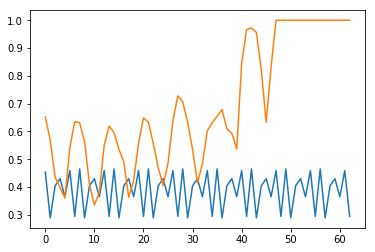

In [104]:
plt.plot(preds)
plt.plot(targets)

In [354]:
# scores

In [64]:
testx=X_loader(test_x,batchsize=128)
testy=Y_loader(test_y,batchsize=128,length_x=len(test_x[0]))


In [65]:
a=next(testx)
b=next(testy)

In [97]:
# from util.evaluation import SMAPE as cpu_SMAPE
# scores=[]
# for (t,p) in zip(truth,pred):
#     scores.append(cpu_SMAPE(t,p))

In [98]:
# np.mean(scores)

In [66]:
preds=recover(preds,test_dic)
recovered_test_x=recover(test_x,test_dic)
targets=recover(targets,test_dic)

In [67]:
from util.evaluation import SMAPE as cpu_SMAPE
mean_scores=[]


for ID in range(40):

    pred=preds[ID]
    truth=targets[ID]
    scores=[]
    for (t,p) in zip(truth,pred):
        scores.append(cpu_SMAPE(t,p))

    mean_scores.append(np.mean(scores))
np.mean(mean_scores)

1.3014198236276102

[3933.1992 2989.226  1860.369  2435.8574 5265.606  5450.9883 5501.077
 4541.0195 3275.4502 2024.4019 2483.2417 5263.4263 5450.919  5501.0527
 4541.008  3275.4458 2024.3992 2483.2407 5263.4263 5450.919  5501.0527
 4541.008  3275.4458 2024.3992 2483.2407 5263.4263 5450.919  5501.0527
 4541.008  3275.4458 2024.3992 2483.2407 5263.4263 5450.919  5501.0527
 4541.008  3275.4458 2024.3992 2483.2407 5263.4263 5450.919  5501.0527
 4541.008  3275.4458 2024.3992 2483.2407 5263.4263 5450.919  5501.0527
 4541.008  3275.4458 2024.3992 2483.2407 5263.4263 5450.919  5501.0527
 4541.008  3275.4458 2024.3992 2483.2407 5263.4263 5450.919  5501.0527]


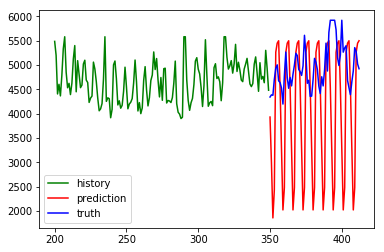

In [68]:
ID=12
# source=sample_series[ID][encode_start:encode_end]
source=recovered_test_x[ID]
pred=preds[ID]
truth=targets[ID]
print(pred)
# for i in range(10):
plt.figure()
plt.plot(np.arange(encode_start,encode_end),source,color='g',label='history')
plt.plot(np.arange(encode_end,encode_end+decode_len),pred,color='r',label='prediction')
plt.plot(np.arange(encode_end,encode_end+decode_len),truth,color='b',label='truth')
plt.legend()

In [96]:
def valid_iter(test_x,test_y):
    testx=X_loader(test_x,batchsize=1)
    testy=Y_loader(test_y,batchsize=1,length_x=len(test_x[0]))

    preds=[]
    targets=[]

    scores=[]
    for j,(X_batch,x_feature) in enumerate(testx):
        #Parse loaded batch
        print(j,end='\r')
        target,y_feature=next(testy)

    
        score,out = valid(X_batch,x_feature, target,y_feature, encoder, decoder, SMAPE)
        out=out.T
        scores.append(score)
        target=target.squeeze().detach().cpu().numpy()
        if j ==0:
            preds=out
            targets=target
        else:
            preds=np.concatenate((preds,out),axis=0)
#             print(preds.shape)
            targets=np.concatenate((targets,target),axis=0)
    return (preds,targets,scores)

In [18]:
# preds
import numpy

def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))
sigmoid(0.)

0.5

In [95]:
use_cuda=True
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
#         self.out = nn.Linear(hidden_size, output_size)
    def forward(self, input_x,feature, hidden):
        #batchsize: bs
        #feature size: fs
        #hidden_size: hs(=bs)
        #input_x:(bs,1,1)
        #feature:(bs,1,fs)
        #hidden:(bs,1,hs)
        gru_input=torch.matmul(input_x,feature)
        #(bs,1,fs)
        output, hidden = self.gru(gru_input, hidden)
        #(bs,1,hs),(bs,1,hs)
        output = torch.sum(feature*output,2,keepdim=True)
        #(bs,1,1)
#         output = torch.sigmoid(output)
         #(bs,1,hs),(bs,1,hs)
        return output, hidden

    def initHidden(self,b_size):
        
#         nn.init.xavier_normal_(self.out)
        paras= nn.init.xavier_normal_(torch.empty(1,b_size,self.hidden_size)).cuda() if use_cuda else \
                nn.init.xavier_normal_(torch.empty(1,b_size,self.hidden_size))
        return paras

class DecoderRNN(nn.Module):
    def __init__(self, input_size,hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
        self.out = nn.Linear(hidden_size, output_size)


    def forward(self, input_x,feature, hidden):
        #batchsize: bs
        #feature size: fs
        #hidden_size: hs(=bs)
        #input_x:(bs,1,1)
        #feature:(bs,1,fs)
        #hidden:(bs,1,hs)
        gru_input=torch.matmul(input_x,feature)
        #(bs,1,fs)

        output, hidden = self.gru(gru_input, hidden)
        #(bs,1,hs),(bs,1,hs)
        output = torch.sum(feature*output,2,keepdim=True)

        #(bs,1,1)
#         output = torch.sigmoid(output)
         #(bs,1,hs),(bs,1,hs)
        return output, hidden
    def initHidden(self):
        paras= nn.init.xavier_normal_(torch.empty(1,1,self.hidden_size)).cuda() if use_cuda else \
                nn.init.xavier_normal_(torch.empty(1,1,self.hidden_size))
        return paras



def train(input_variable, input_feature, target_variable, target_feature, encoder, decoder, encoder_optimizer, \
          decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    encoder_hidden = encoder.initHidden(input_variable.size(0))

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
    
    encoder_outputs = torch.zeros(input_length, encoder.hidden_size)
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss_encoding = 0
    
#     hidden_link=torch.empty(encoder_hidden.size(0),encoder_hidden.size(1),encoder_hidden.size(2)).cuda()
#     N=0
    for ei in range(input_length-1):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei:(ei+1),:],input_feature[:,ei:(ei+1),:], encoder_hidden)
        loss_encoding += criterion(encoder_output.squeeze(),input_variable[:,ei+1:(ei+2),:].squeeze())
        encoder_outputs[ei] = encoder_output[0,0,:]
        
#         if ei % 7 == 0:
#             N+=1
#             hidden_link+=encoder_hidden
#     hidden_link=hidden_link/N
#             print(ei)
#             print('hidden',encoder_hidden[:,:10,:])
#     print('-'*90)
#     print('pred')
#     print(encoder_output.size())
#     print(encoder_output)
#     print('target')
#     print(input_variable[:,ei+1:(ei+2),:].size())
#     print(input_variable[:,ei+1:(ei+2),:])
#     print(criterion(encoder_output.squeeze(),input_variable[:,ei+1:(ei+2),:].squeeze()))
#     print('-'*90)
    #get the first prediction
    encoder_output, encoder_hidden = encoder(input_variable[:,ei+1:(ei+2),:],input_feature[:,ei+1:(ei+2),:],\
                                             encoder_hidden)
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden
#     print(input_variable[:,-1,:])
#     print(decoder_hidden)
#     print('_'*90)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    loss_decoding=0
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
#             print(decoder_hidden.size())
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)
        
            
            decoder_output, decoder_hidden = decoder(
                decoder_input,target_feature[:,di:(di+1),:], encoder_hidden)
        
            loss_decoding += criterion(decoder_output.squeeze(), target_variable[:,di:di+1,:].squeeze())
            decoder_input = target_variable[:,di:di+1,:]  # Teacher forcing

    else:
#         print('real start')
#         print(input_variable[:,ei:(ei+1),:])
#         print('encode start')
#         print(decoder_input)
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
#             print(decoder_hidden.size())
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)
        
            
            decoder_output, decoder_hidden = decoder(
                decoder_input,target_feature[:,di:(di+1),:], encoder_hidden)

            
            decoder_input = decoder_output
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
#             print('sizes')
#             print(decoder_output.size(),target_variable[:,di:di+1,:].size())
#             print('pred')
#             print(decoder_output)
#             print('truth')
#             print(target_variable[:,di:di+1,:])
#             print('-'*90)
            loss_decoding += criterion(decoder_output.squeeze(), target_variable[:,di:di+1,:].squeeze())
#     loss=loss_encoding+loss_decoding
    loss=loss_decoding
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ((loss_encoding.item() / (input_length-1)),(loss_decoding.item() / target_length))

In [99]:
def valid(input_variable, input_feature, target_variable, target_feature, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    encoder_hidden = encoder.initHidden(input_variable.size(0))
    
    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
#     print(target_length)
    
    loss = 0
    
#     hidden_link=torch.empty(encoder_hidden.size(0),encoder_hidden.size(1),encoder_hidden.size(2)).cuda()
    
#     N=0
    for ei in range(input_length):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei:(ei+1),:],input_feature[:,ei:(ei+1),:], encoder_hidden)
        
#         if ei % 7 == 0:
#             N+=1
#             hidden_link+=encoder_hidden
#             print(ei)
#             print('hidden',encoder_hidden[:,:10,:])
    
#     hidden_link=hidden_link/N
    
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
#             loss += criterion(decoder_output, target_variable[:,di:di+1,:])
#             decoder_input = target_variable[:,di:di+1,:]  # Teacher forcing

#     else:
        # Without teacher forcing: use its own predictions as the next input
    outputs=[]
#     print('!'*90)
    for di in range(target_length):
#         decoder_output, decoder_hidden = decoder(
#             decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)


        decoder_output, decoder_hidden = decoder(
            decoder_input,target_feature[:,di:(di+1),:], encoder_hidden)
#         print('-'*90)
#         print('in',decoder_input.size())
#         print('in',target_feature[:,0,:].size())
#         print('hidden',encoder_hidden.size())
#         print('out',decoder_hidden.size())
        
        
#         print('in',decoder_input[0,:,:])
#         print('in',target_feature[0,di,:])
#         print('hidden',hidden_link[:,:10,:])
#         print('out',decoder_hidden[:,0,:])
#         print('out',decoder_output[0,:,:])
        
#         decoder_output, decoder_hidden = decoder(
#             decoder_input,target_feature[:,di:(di+1),:], encoder_hidden+0.1)
        
#         print('in',decoder_input[0,:,:])
#         print('in',target_feature[0,di,:])
#         print('hidden',encoder_hidden[:,0,:]+0.1)
#         print('out',decoder_hidden[:,0,:])
#         print('out',decoder_output[0,:,:])        
        
#         decoder_output, decoder_hidden = decoder(
#         decoder_input,target_feature[:,di:(di+1),:], encoder_hidden+0.3)
        
#         print('in',decoder_input[0,:,:])
#         print('in',target_feature[0,di,:])
#         print('hidden',encoder_hidden[:,0,:]+0.3)
#         print('out',decoder_hidden[:,0,:])
#         print('out',decoder_output[0,:,:]) 
        
        decoder_input = decoder_output
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        outputs.append(decoder_output.squeeze().detach().cpu().numpy())
#         print(decoder_output.size(), target_variable[:,di:di+1,:].size())
#         print(decoder_output.size(), target_variable[:,di:di+1,:].size())
        loss += criterion(decoder_output, target_variable[:,di:di+1,:])


    return (loss.item() / target_length,np.array(outputs))

In [84]:
preds[0]

array([0.5090716 , 0.50754863, 0.49179465, 0.49177837, 0.48591298,
       0.482741  , 0.46966267, 0.47118858, 0.4909701 , 0.48962954,
       0.4917352 , 0.4859075 , 0.4827402 , 0.46966234, 0.47118852,
       0.49097002, 0.48962954, 0.4917352 , 0.4859075 , 0.4827402 ,
       0.46966234, 0.47118852, 0.49097002, 0.48962954, 0.4917352 ,
       0.4859075 , 0.4827402 , 0.46966234, 0.47118852, 0.49097002,
       0.48962954, 0.4917352 , 0.4859075 , 0.4827402 , 0.46966234,
       0.47118852, 0.49097002, 0.48962954, 0.4917352 , 0.4859075 ,
       0.4827402 , 0.46966234, 0.47118852, 0.49097002, 0.48962954,
       0.4917352 , 0.4859075 , 0.4827402 , 0.46966234, 0.47118852,
       0.49097002, 0.48962954, 0.4917352 , 0.4859075 , 0.4827402 ,
       0.46966234, 0.47118852, 0.49097002, 0.48962954, 0.4917352 ,
       0.4859075 , 0.4827402 , 0.46966234], dtype=float32)

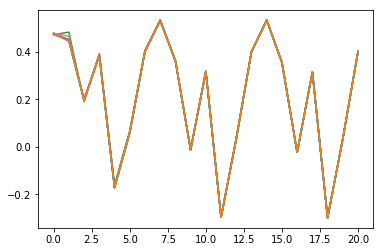

In [45]:
for i in range(12):
    plt.plot(preds[i][:21])
#     plt.plot(preds[213])

In [164]:
preds[45]

array([-0.2906543 ,  0.00244739,  0.00105445, -0.29007328,  0.00051828,
       -0.05483976,  0.32942048, -0.29045188,  0.00248676,  0.00105351,
       -0.2900731 ,  0.00051828, -0.05483976,  0.32942048, -0.29045188,
        0.00248676,  0.00105351, -0.2900731 ,  0.00051828, -0.05483976,
        0.32942048, -0.29045188,  0.00248676,  0.00105351, -0.2900731 ,
        0.00051828, -0.05483976,  0.32942048, -0.29045188,  0.00248676,
        0.00105351, -0.2900731 ,  0.00051828, -0.05483976,  0.32942048,
       -0.29045188,  0.00248676,  0.00105351, -0.2900731 ,  0.00051828,
       -0.05483976,  0.32942048, -0.29045188,  0.00248676,  0.00105351,
       -0.2900731 ,  0.00051828, -0.05483976,  0.32942048, -0.29045188,
        0.00248676,  0.00105351, -0.2900731 ,  0.00051828, -0.05483976,
        0.32942048, -0.29045188,  0.00248676,  0.00105351, -0.2900731 ,
        0.00051828, -0.05483976,  0.32942048], dtype=float32)

In [47]:
preds,targets,scores=valid_iter(test_x,test_y)

0
hidden tensor([[[ 0.1262,  0.3320,  0.1249,  0.1863,  0.2817,  0.2901,  0.0702],
         [ 0.1335,  0.3058,  0.1433,  0.1404,  0.2459,  0.3234,  0.1217],
         [ 0.1297,  0.2634,  0.1310,  0.1868,  0.2704,  0.3089,  0.0880],
         [ 0.1248,  0.2883,  0.1397,  0.1715,  0.2944,  0.3367,  0.1177],
         [ 0.1247,  0.2845,  0.1848,  0.2179,  0.2405,  0.3060,  0.1436],
         [ 0.1080,  0.3383,  0.1232,  0.1634,  0.2396,  0.2748,  0.1464],
         [ 0.0570,  0.3153,  0.1635,  0.1606,  0.3196,  0.3113,  0.1001],
         [ 0.1727,  0.3077,  0.1529,  0.1721,  0.3184,  0.3403,  0.1713],
         [ 0.1145,  0.3099,  0.1356,  0.1588,  0.3401,  0.3018,  0.0492],
         [ 0.0646,  0.2803,  0.1686,  0.1887,  0.2339,  0.3021,  0.0836]]], device='cuda:0')
7
hidden tensor([[[ 0.6359,  0.6177,  0.3672,  0.3102,  0.5539,  0.7485,  0.3975],
         [ 0.6332,  0.6110,  0.3637,  0.3107,  0.5445,  0.7424,  0.4079],
         [ 0.6287,  0.6019,  0.3738,  0.3131,  0.5290,  0.7424,  0.4171],
 

hidden tensor([[[ 0.6748,  0.6189,  0.3695,  0.3282,  0.5389,  0.7713,  0.4378],
         [ 0.6732,  0.6146,  0.3699,  0.3273,  0.5312,  0.7691,  0.4444],
         [ 0.6711,  0.6165,  0.3754,  0.3134,  0.5356,  0.7710,  0.4349],
         [ 0.6819,  0.6317,  0.3684,  0.3156,  0.5662,  0.7709,  0.4179],
         [ 0.6786,  0.6222,  0.3652,  0.3098,  0.5423,  0.7721,  0.4364],
         [ 0.6774,  0.6208,  0.3695,  0.3150,  0.5442,  0.7692,  0.4362],
         [ 0.6858,  0.6280,  0.3311,  0.3159,  0.5632,  0.7542,  0.4383],
         [ 0.6777,  0.6246,  0.3704,  0.3167,  0.5499,  0.7725,  0.4287],
         [ 0.6918,  0.6409,  0.3525,  0.3064,  0.5762,  0.7724,  0.4200],
         [ 0.6890,  0.6221,  0.3938,  0.2944,  0.5489,  0.7752,  0.4398]]], device='cuda:0')
28
hidden tensor([[[ 0.6765,  0.6236,  0.3664,  0.3265,  0.5480,  0.7715,  0.4307],
         [ 0.6778,  0.6334,  0.3536,  0.3364,  0.5630,  0.7739,  0.4154],
         [ 0.6744,  0.6153,  0.3714,  0.3344,  0.5315,  0.7723,  0.4442],
  

35
hidden tensor([[[ 0.6891,  0.6463,  0.3258,  0.3090,  0.5909,  0.7623,  0.4070],
         [ 0.6765,  0.6213,  0.3706,  0.3181,  0.5430,  0.7711,  0.4353],
         [ 0.6782,  0.6210,  0.3681,  0.3140,  0.5443,  0.7692,  0.4368],
         [ 0.6745,  0.6104,  0.3903,  0.3000,  0.5272,  0.7688,  0.4448],
         [ 0.6844,  0.6430,  0.3267,  0.3341,  0.5831,  0.7667,  0.4052],
         [ 0.6800,  0.6309,  0.3471,  0.3377,  0.5581,  0.7710,  0.4253],
         [ 0.6829,  0.6309,  0.3455,  0.3214,  0.5610,  0.7661,  0.4290],
         [ 0.6781,  0.6206,  0.3698,  0.3125,  0.5433,  0.7697,  0.4374],
         [ 0.6759,  0.6175,  0.3746,  0.3144,  0.5381,  0.7698,  0.4396],
         [ 0.6883,  0.6395,  0.3570,  0.2954,  0.5776,  0.7700,  0.4142]]], device='cuda:0')
42
hidden tensor([[[ 0.6798,  0.6128,  0.3803,  0.3006,  0.5276,  0.7693,  0.4527],
         [ 0.6772,  0.6180,  0.3679,  0.3223,  0.5376,  0.7694,  0.4429],
         [ 0.6779,  0.6193,  0.3726,  0.3137,  0.5411,  0.7699,  0.4395],

56
hidden tensor([[[ 0.6799,  0.6180,  0.3763,  0.3102,  0.5401,  0.7678,  0.4438],
         [ 0.6803,  0.6206,  0.3732,  0.3155,  0.5446,  0.7709,  0.4376],
         [ 0.6774,  0.6205,  0.3697,  0.3152,  0.5438,  0.7693,  0.4366],
         [ 0.6452,  0.5597,  0.4398,  0.3197,  0.4312,  0.7673,  0.4918],
         [ 0.6794,  0.6209,  0.3584,  0.3206,  0.5457,  0.7651,  0.4405],
         [ 0.6696,  0.6102,  0.3892,  0.3069,  0.5267,  0.7705,  0.4403],
         [ 0.6804,  0.6165,  0.3616,  0.2989,  0.5384,  0.7612,  0.4484],
         [ 0.6805,  0.6212,  0.3411,  0.3323,  0.5416,  0.7627,  0.4490],
         [ 0.6787,  0.6317,  0.3753,  0.3049,  0.5660,  0.7736,  0.4112],
         [ 0.6794,  0.6245,  0.3648,  0.3134,  0.5508,  0.7690,  0.4323]]], device='cuda:0')
63
hidden tensor([[[ 0.6780,  0.6170,  0.3770,  0.3091,  0.5372,  0.7706,  0.4420],
         [ 0.6757,  0.6131,  0.3832,  0.2917,  0.5390,  0.7606,  0.4412],
         [ 0.6774,  0.6205,  0.3697,  0.3152,  0.5438,  0.7693,  0.4366],

77
hidden tensor([[[ 0.6764,  0.6182,  0.3714,  0.3158,  0.5394,  0.7691,  0.4395],
         [ 0.6770,  0.6165,  0.3743,  0.3119,  0.5366,  0.7687,  0.4427],
         [ 0.6856,  0.6334,  0.3596,  0.3365,  0.5622,  0.7786,  0.4230],
         [ 0.6452,  0.5597,  0.4398,  0.3197,  0.4312,  0.7673,  0.4918],
         [ 0.6807,  0.6285,  0.3575,  0.3145,  0.5611,  0.7656,  0.4258],
         [ 0.7026,  0.6702,  0.2970,  0.3153,  0.6349,  0.7623,  0.3698],
         [ 0.6781,  0.6228,  0.3670,  0.3146,  0.5477,  0.7691,  0.4335],
         [ 0.6704,  0.5975,  0.3850,  0.3056,  0.4996,  0.7655,  0.4674],
         [ 0.6741,  0.6141,  0.3855,  0.3109,  0.5312,  0.7726,  0.4416],
         [ 0.6805,  0.6318,  0.3519,  0.3224,  0.5640,  0.7688,  0.4208]]], device='cuda:0')
84
hidden tensor([[[ 0.6773,  0.6205,  0.3689,  0.3162,  0.5442,  0.7687,  0.4364],
         [ 0.6818,  0.6275,  0.3602,  0.3122,  0.5571,  0.7684,  0.4294],
         [ 0.6714,  0.6101,  0.3793,  0.3250,  0.5223,  0.7706,  0.4489],

91
hidden tensor([[[ 0.6781,  0.6358,  0.3728,  0.2949,  0.5781,  0.7674,  0.3999],
         [ 0.6802,  0.6427,  0.3704,  0.3093,  0.5839,  0.7758,  0.3910],
         [ 0.6760,  0.6175,  0.3739,  0.3154,  0.5381,  0.7696,  0.4399],
         [ 0.6742,  0.6117,  0.3901,  0.2931,  0.5297,  0.7679,  0.4439],
         [ 0.6452,  0.5597,  0.4398,  0.3197,  0.4312,  0.7673,  0.4918],
         [ 0.6827,  0.6301,  0.3598,  0.3148,  0.5563,  0.7706,  0.4309],
         [ 0.6821,  0.6176,  0.3516,  0.3104,  0.5420,  0.7583,  0.4517],
         [ 0.6750,  0.6165,  0.3797,  0.3153,  0.5345,  0.7724,  0.4403],
         [ 0.6781,  0.6274,  0.3608,  0.3249,  0.5541,  0.7712,  0.4265],
         [ 0.6789,  0.6237,  0.3657,  0.3154,  0.5493,  0.7692,  0.4330]]], device='cuda:0')
98
hidden tensor([[[ 0.6767,  0.6196,  0.3698,  0.3138,  0.5405,  0.7704,  0.4380],
         [ 0.6810,  0.6139,  0.3645,  0.3142,  0.5297,  0.7664,  0.4568],
         [ 0.6759,  0.6175,  0.3741,  0.3153,  0.5382,  0.7695,  0.4398],

105
hidden tensor([[[ 0.6781,  0.6235,  0.3730,  0.3054,  0.5536,  0.7664,  0.4281],
         [ 0.6715,  0.6155,  0.3731,  0.3121,  0.5345,  0.7671,  0.4386],
         [ 0.6802,  0.6316,  0.3591,  0.3167,  0.5633,  0.7713,  0.4184],
         [ 0.6859,  0.6390,  0.3668,  0.3165,  0.5781,  0.7738,  0.4092],
         [ 0.6796,  0.6065,  0.3813,  0.2893,  0.5258,  0.7585,  0.4587],
         [ 0.6874,  0.6371,  0.3567,  0.3069,  0.5729,  0.7700,  0.4180],
         [ 0.6781,  0.6188,  0.3625,  0.3235,  0.5400,  0.7673,  0.4435],
         [ 0.6875,  0.6520,  0.3199,  0.3093,  0.6067,  0.7589,  0.3872],
         [ 0.6810,  0.6429,  0.3469,  0.3379,  0.5807,  0.7762,  0.3973],
         [ 0.6870,  0.6564,  0.3269,  0.3494,  0.6029,  0.7774,  0.3755]]], device='cuda:0')
112
hidden tensor([[[ 0.6763,  0.6205,  0.3691,  0.3171,  0.5436,  0.7695,  0.4356],
         [ 0.6800,  0.6229,  0.3644,  0.3041,  0.5514,  0.7647,  0.4350],
         [ 0.6933,  0.6540,  0.3222,  0.2891,  0.6084,  0.7590,  0.3928

112
hidden tensor([[[ 0.6708,  0.6112,  0.3816,  0.3251,  0.5248,  0.7709,  0.4460],
         [ 0.6770,  0.6138,  0.3659,  0.3033,  0.5381,  0.7577,  0.4469],
         [ 0.6775,  0.6183,  0.3779,  0.3140,  0.5401,  0.7708,  0.4392],
         [ 0.7000,  0.6757,  0.2810,  0.3160,  0.6474,  0.7564,  0.3494],
         [ 0.6765,  0.6301,  0.3507,  0.3381,  0.5561,  0.7721,  0.4223],
         [ 0.6759,  0.6182,  0.3716,  0.3160,  0.5397,  0.7689,  0.4389],
         [ 0.6813,  0.6362,  0.3512,  0.3312,  0.5686,  0.7733,  0.4141],
         [ 0.6452,  0.5597,  0.4398,  0.3197,  0.4312,  0.7673,  0.4918],
         [ 0.6853,  0.6410,  0.3493,  0.2915,  0.5887,  0.7591,  0.4025],
         [ 0.6759,  0.6131,  0.3864,  0.3102,  0.5290,  0.7722,  0.4457]]], device='cuda:0')
119
hidden tensor([[[ 0.6728,  0.6098,  0.3816,  0.3190,  0.5249,  0.7688,  0.4493],
         [ 0.6857,  0.6274,  0.3475,  0.3196,  0.5562,  0.7669,  0.4382],
         [ 0.6764,  0.6167,  0.3786,  0.3078,  0.5370,  0.7698,  0.4404

hidden tensor([[[ 0.6875,  0.6615,  0.3239,  0.3464,  0.6120,  0.7782,  0.3635],
         [ 0.6792,  0.6248,  0.3565,  0.3271,  0.5477,  0.7703,  0.4351],
         [ 0.6786,  0.6234,  0.3662,  0.3142,  0.5489,  0.7691,  0.4331],
         [ 0.6858,  0.6420,  0.3520,  0.3049,  0.5791,  0.7736,  0.4075],
         [ 0.6800,  0.6260,  0.3634,  0.3145,  0.5534,  0.7694,  0.4302],
         [ 0.6840,  0.6400,  0.3510,  0.3110,  0.5762,  0.7726,  0.4095],
         [ 0.6901,  0.6503,  0.3394,  0.3070,  0.5952,  0.7713,  0.3969],
         [ 0.6815,  0.6293,  0.3652,  0.3085,  0.5614,  0.7688,  0.4235],
         [ 0.6815,  0.6378,  0.3639,  0.3246,  0.5707,  0.7783,  0.4079],
         [ 0.6452,  0.5597,  0.4398,  0.3197,  0.4312,  0.7673,  0.4918]]], device='cuda:0')
133
hidden tensor([[[ 0.6799,  0.6270,  0.3611,  0.3171,  0.5537,  0.7692,  0.4301],
         [ 0.6807,  0.6295,  0.3519,  0.3136,  0.5615,  0.7650,  0.4267],
         [ 0.6789,  0.6234,  0.3667,  0.3143,  0.5493,  0.7690,  0.4332],
 

147
hidden tensor([[[ 0.6861,  0.6680,  0.3172,  0.3322,  0.6230,  0.7772,  0.3495],
         [ 0.6787,  0.6230,  0.3666,  0.3143,  0.5482,  0.7693,  0.4336],
         [ 0.6726,  0.6065,  0.3965,  0.2917,  0.5197,  0.7687,  0.4492],
         [ 0.6713,  0.6075,  0.3873,  0.3142,  0.5192,  0.7708,  0.4505],
         [ 0.6745,  0.6127,  0.3756,  0.3005,  0.5324,  0.7643,  0.4443],
         [ 0.6894,  0.6407,  0.3202,  0.3078,  0.5825,  0.7568,  0.4209],
         [ 0.6876,  0.6430,  0.3166,  0.3053,  0.5858,  0.7581,  0.4145],
         [ 0.6764,  0.6181,  0.3735,  0.3142,  0.5391,  0.7696,  0.4393],
         [ 0.6774,  0.6235,  0.3684,  0.3182,  0.5481,  0.7714,  0.4312],
         [ 0.6695,  0.6056,  0.3889,  0.3175,  0.5155,  0.7706,  0.4518]]], device='cuda:0')
hidden tensor([[[ 0.6537,  0.6122,  2.3350,  0.3068,  2.6315,  0.7481,  2.3867],
         [ 0.6521,  0.6107,  0.3539,  0.3056,  0.5418,  0.7486,  0.4110],
         [ 0.6524,  0.5973,  0.3763,  0.2851,  0.5303,  0.7439,  0.4243],
 

hidden tensor([[[ 0.6536,  0.6171,  2.2701,  0.3138,  0.5522,  0.7498,  0.4058],
         [ 0.6523,  0.6138,  0.3481,  0.3093,  0.5410,  0.7453,  0.4079],
         [ 0.6546,  0.6171,  0.3390,  0.3137,  0.5504,  0.7439,  0.4068],
         [ 0.6549,  0.6099,  0.3515,  0.3111,  0.5424,  0.7456,  0.4148],
         [ 0.6465,  0.6107,  0.3555,  0.3069,  0.5421,  0.7430,  0.4140],
         [ 0.6527,  0.6147,  0.3494,  0.2988,  0.5424,  0.7484,  0.4060],
         [ 0.6534,  0.6108,  0.3518,  0.3110,  0.5475,  0.7461,  0.4100],
         [ 0.6481,  0.6112,  0.3555,  0.3096,  0.5435,  0.7411,  0.4200],
         [ 0.6510,  0.6149,  0.3554,  0.3114,  0.5450,  0.7498,  0.4063],
         [ 0.6559,  0.6103,  0.3576,  0.3120,  0.5433,  0.7504,  0.4097]]], device='cuda:0')
hidden tensor([[[ 0.6536,  0.6171,  2.2701,  0.3138,  0.5522,  0.7498,  0.4058],
         [ 0.6523,  0.6138,  0.3481,  0.3093,  0.5410,  0.7453,  0.4079],
         [ 0.6546,  0.6171,  0.3390,  0.3137,  0.5504,  0.7439,  0.4068],
     

hidden tensor([[[ 0.6518,  0.6181,  2.2911,  0.3152,  0.5524,  0.7505,  0.4005],
         [ 0.6503,  0.6183,  0.3473,  0.3084,  0.5501,  0.7508,  0.4052],
         [ 0.6565,  0.6185,  0.3485,  0.3164,  0.5462,  0.7458,  0.4184],
         [ 0.6530,  0.6171,  0.3416,  0.3139,  0.5515,  0.7465,  0.3992],
         [ 0.6479,  0.6068,  0.3550,  0.3052,  0.5411,  0.7480,  0.4069],
         [ 0.6453,  0.5945,  0.3711,  0.2863,  0.5283,  0.7476,  0.4276],
         [ 0.6189,  0.5447,  0.4284,  0.3105,  0.4222,  0.7398,  0.4745],
         [ 0.6514,  0.6151,  0.3496,  0.3040,  0.5462,  0.7479,  0.4107],
         [ 0.6520,  0.6102,  0.3485,  0.3118,  0.5408,  0.7493,  0.4117],
         [ 0.6524,  0.6224,  0.3445,  0.3176,  0.5520,  0.7491,  0.3989]]], device='cuda:0')
hidden tensor([[[ 0.6518,  0.6181,  2.2911,  0.3152,  0.5524,  0.7505,  0.4005],
         [ 0.6503,  0.6183,  0.3473,  0.3084,  0.5501,  0.7508,  0.4052],
         [ 0.6565,  0.6185,  0.3485,  0.3164,  0.5462,  0.7458,  0.4184],
     

hidden tensor([[[ 2.7180,  0.6242,  2.3591,  0.3279,  2.6214,  0.7470,  2.4342],
         [ 0.6535,  0.6119,  0.3521,  0.3129,  0.5437,  0.7440,  0.4081],
         [ 0.6511,  0.6039,  0.3702,  0.3016,  0.5296,  0.7547,  0.4233],
         [ 0.6603,  0.6111,  0.3497,  0.3103,  0.5494,  0.7517,  0.4064],
         [ 0.6460,  0.6104,  0.3523,  0.3031,  0.5369,  0.7472,  0.4141],
         [ 0.6532,  0.6075,  0.3510,  0.3056,  0.5465,  0.7491,  0.4077],
         [ 0.6231,  0.5392,  0.4256,  0.3137,  0.4232,  0.7410,  0.4713],
         [ 0.6508,  0.6004,  0.3728,  0.2878,  0.5306,  0.7465,  0.4184],
         [ 0.6511,  0.6124,  0.3477,  0.3096,  0.5438,  0.7453,  0.4138],
         [ 0.6608,  0.6247,  0.3286,  0.3300,  0.5672,  0.7534,  0.3934]]], device='cuda:0')
hidden tensor([[[ 2.7180,  0.6242,  2.3591,  0.3279,  2.6214,  0.7470,  2.4342],
         [ 0.6535,  0.6119,  0.3521,  0.3129,  0.5437,  0.7440,  0.4081],
         [ 0.6511,  0.6039,  0.3702,  0.3016,  0.5296,  0.7547,  0.4233],
     

hidden tensor([[[ 0.6498,  0.6136,  7.9749,  0.3047,  0.5435,  0.7445,  0.4094],
         [ 0.6529,  0.6130,  0.3565,  0.3125,  0.5457,  0.7511,  0.4056],
         [ 0.6554,  0.6118,  0.3470,  0.3131,  0.5478,  0.7427,  0.4081],
         [ 0.6543,  0.6104,  0.3465,  0.3056,  0.5444,  0.7461,  0.4097],
         [ 0.6571,  0.6171,  0.3438,  0.3091,  0.5449,  0.7457,  0.4034],
         [ 0.6496,  0.6121,  0.3531,  0.3082,  0.5437,  0.7496,  0.4121],
         [ 0.6536,  0.6133,  0.3511,  0.3072,  0.5545,  0.7475,  0.3930],
         [ 0.6139,  0.5419,  0.4216,  0.3102,  0.4243,  0.7426,  0.4733],
         [ 0.6582,  0.6134,  0.3511,  0.3100,  0.5472,  0.7458,  0.4098],
         [ 0.6472,  0.6165,  0.3523,  0.3115,  0.5377,  0.7497,  0.4139]]], device='cuda:0')
hidden tensor([[[ 0.6498,  0.6136,  7.9749,  0.3047,  0.5435,  0.7445,  0.4094],
         [ 0.6529,  0.6130,  0.3565,  0.3125,  0.5457,  0.7511,  0.4056],
         [ 0.6554,  0.6118,  0.3470,  0.3131,  0.5478,  0.7427,  0.4081],
     

hidden tensor([[[ 0.6540,  0.6113,  2.3767,  0.3090,  0.5393,  0.7457,  0.4154],
         [ 0.6517,  0.6101,  0.3452,  0.3014,  0.5454,  0.7396,  0.4065],
         [ 0.6550,  0.6134,  0.3585,  0.3008,  0.5411,  0.7513,  0.4077],
         [ 0.6581,  0.6139,  0.3505,  0.3054,  0.5431,  0.7421,  0.4083],
         [ 0.6497,  0.6101,  0.3439,  0.3130,  0.5463,  0.7484,  0.4106],
         [ 0.6540,  0.6117,  0.3538,  0.3014,  0.5449,  0.7473,  0.4114],
         [ 0.6554,  0.6175,  0.3366,  0.3170,  0.5515,  0.7476,  0.4072],
         [ 0.6217,  0.5427,  0.4291,  0.3097,  0.4238,  0.7461,  0.4742],
         [ 0.6554,  0.6214,  0.3622,  0.3050,  0.5458,  0.7483,  0.4104],
         [ 0.6518,  0.6134,  0.3438,  0.3113,  0.5471,  0.7467,  0.4054]]], device='cuda:0')
hidden tensor([[[ 0.6540,  0.6113,  2.3767,  0.3090,  0.5393,  0.7457,  0.4154],
         [ 0.6517,  0.6101,  0.3452,  0.3014,  0.5454,  0.7396,  0.4065],
         [ 0.6550,  0.6134,  0.3585,  0.3008,  0.5411,  0.7513,  0.4077],
     

hidden tensor([[[ 2.1157,  0.6135,  2.4294,  0.3036,  2.0087,  0.7456,  2.4918],
         [ 0.6509,  0.6168,  0.3496,  0.3093,  0.5419,  0.7415,  0.4043],
         [ 0.6487,  0.6142,  0.3491,  0.2936,  0.5505,  0.7388,  0.4114],
         [ 0.6499,  0.6086,  0.3475,  0.3017,  0.5434,  0.7499,  0.4127],
         [ 0.6517,  0.6164,  0.3495,  0.3121,  0.5531,  0.7499,  0.4041],
         [ 0.6544,  0.6146,  0.3561,  0.3079,  0.5434,  0.7484,  0.4151],
         [ 0.6541,  0.6096,  0.3499,  0.3088,  0.5424,  0.7452,  0.4141],
         [ 0.6549,  0.6148,  0.3446,  0.3121,  0.5469,  0.7501,  0.4144],
         [ 0.6519,  0.6145,  0.3421,  0.3160,  0.5522,  0.7484,  0.4012],
         [ 0.6462,  0.6045,  0.3725,  0.2917,  0.5257,  0.7521,  0.4290]]], device='cuda:0')
hidden tensor([[[ 2.1157,  0.6135,  2.4294,  0.3036,  2.0087,  0.7456,  2.4918],
         [ 0.6509,  0.6168,  0.3496,  0.3093,  0.5419,  0.7415,  0.4043],
         [ 0.6487,  0.6142,  0.3491,  0.2936,  0.5505,  0.7388,  0.4114],
     

hidden tensor([[[ 0.6503,  0.6162,  2.1746,  0.3074,  2.5339,  0.7482,  2.3273],
         [ 0.6164,  0.5473,  0.4284,  0.3063,  0.4177,  0.7440,  0.4697],
         [ 0.6544,  0.6139,  0.3484,  0.3107,  0.5471,  0.7447,  0.4031],
         [ 0.6475,  0.6078,  0.3718,  0.2956,  0.5240,  0.7470,  0.4196],
         [ 0.6534,  0.6175,  0.3503,  0.3114,  0.5537,  0.7502,  0.4126],
         [ 0.6549,  0.6121,  0.3502,  0.3111,  0.5452,  0.7468,  0.4119],
         [ 0.6580,  0.6210,  0.3357,  0.3170,  0.5582,  0.7449,  0.3993],
         [ 0.6573,  0.6204,  0.3416,  0.3099,  0.5495,  0.7474,  0.4041],
         [ 0.6521,  0.6171,  0.3537,  0.3117,  0.5408,  0.7471,  0.4086],
         [ 0.6522,  0.6219,  0.3490,  0.3219,  0.5576,  0.7438,  0.4002]]], device='cuda:0')
hidden tensor([[[ 0.6503,  0.6162,  2.1746,  0.3074,  2.5339,  0.7482,  2.3273],
         [ 0.6164,  0.5473,  0.4284,  0.3063,  0.4177,  0.7440,  0.4697],
         [ 0.6544,  0.6139,  0.3484,  0.3107,  0.5471,  0.7447,  0.4031],
     

hidden tensor([[[ 0.6529,  0.6141,  2.2972,  0.3075,  0.5443,  0.7453,  0.4073],
         [ 0.6535,  0.6099,  0.3488,  0.3077,  0.5481,  0.7452,  0.4126],
         [ 0.6530,  0.6179,  0.3337,  0.3168,  0.5473,  0.7461,  0.4049],
         [ 0.6548,  0.6134,  0.3424,  0.3097,  0.5512,  0.7435,  0.4089],
         [ 0.6553,  0.6067,  0.3401,  0.3140,  0.5452,  0.7455,  0.4030],
         [ 0.6492,  0.6120,  0.3565,  0.2992,  0.5381,  0.7526,  0.4153],
         [ 0.6154,  0.5438,  0.4313,  0.3100,  0.4194,  0.7408,  0.4830],
         [ 0.6504,  0.6110,  0.3515,  0.3122,  0.5349,  0.7458,  0.4110],
         [ 0.6566,  0.6191,  0.3499,  0.3068,  0.5461,  0.7483,  0.4132],
         [ 0.6568,  0.6234,  0.3425,  0.3293,  0.5590,  0.7504,  0.3906]]], device='cuda:0')
hidden tensor([[[ 0.6529,  0.6141,  2.2972,  0.3075,  0.5443,  0.7453,  0.4073],
         [ 0.6535,  0.6099,  0.3488,  0.3077,  0.5481,  0.7452,  0.4126],
         [ 0.6530,  0.6179,  0.3337,  0.3168,  0.5473,  0.7461,  0.4049],
     

hidden tensor([[[ 0.6545,  0.6138,  1.6909,  0.3064,  0.5456,  0.7463,  0.4103],
         [ 0.6534,  0.6164,  0.3462,  0.3140,  0.5487,  0.7471,  0.4037],
         [ 0.6546,  0.6103,  0.3522,  0.3132,  0.5482,  0.7527,  0.4051],
         [ 0.6541,  0.6125,  0.3542,  0.3050,  0.5433,  0.7470,  0.4130],
         [ 0.6630,  0.6111,  0.3561,  0.3075,  0.5459,  0.7458,  0.4187],
         [ 0.6529,  0.6144,  0.3549,  0.3034,  0.5458,  0.7518,  0.4107],
         [ 0.6556,  0.6143,  0.3472,  0.3056,  0.5511,  0.7454,  0.4123],
         [ 0.6468,  0.6142,  0.3549,  0.3108,  0.5392,  0.7471,  0.4124],
         [ 0.6165,  0.5520,  0.4294,  0.3122,  0.4257,  0.7434,  0.4685],
         [ 0.6535,  0.6088,  0.3483,  0.3114,  0.5442,  0.7449,  0.4094]]], device='cuda:0')
hidden tensor([[[ 0.6545,  0.6138,  1.6909,  0.3064,  0.5456,  0.7463,  0.4103],
         [ 0.6534,  0.6164,  0.3462,  0.3140,  0.5487,  0.7471,  0.4037],
         [ 0.6546,  0.6103,  0.3522,  0.3132,  0.5482,  0.7527,  0.4051],
     

hidden tensor([[[ 2.0979,  0.6149,  1.6866,  0.3060,  1.9918,  0.7469,  1.7445],
         [ 0.6557,  0.6145,  0.3486,  0.3093,  0.5450,  0.7479,  0.4085],
         [ 0.6509,  0.6121,  0.3499,  0.3057,  0.5468,  0.7409,  0.4155],
         [ 0.6605,  0.6232,  0.3332,  0.3192,  0.5602,  0.7511,  0.3926],
         [ 0.6536,  0.6081,  0.3528,  0.3066,  0.5449,  0.7471,  0.4117],
         [ 0.6505,  0.6086,  0.3455,  0.3117,  0.5428,  0.7420,  0.4122],
         [ 0.6566,  0.6123,  0.3429,  0.3083,  0.5514,  0.7440,  0.4093],
         [ 0.6496,  0.6087,  0.3651,  0.3092,  0.5393,  0.7442,  0.4157],
         [ 0.6586,  0.6104,  0.3453,  0.3130,  0.5391,  0.7454,  0.4126],
         [ 0.6543,  0.6069,  0.3543,  0.3059,  0.5413,  0.7509,  0.4115]]], device='cuda:0')
hidden tensor([[[ 2.0979,  0.6149,  1.6866,  0.3060,  1.9918,  0.7469,  1.7445],
         [ 0.6557,  0.6145,  0.3486,  0.3093,  0.5450,  0.7479,  0.4085],
         [ 0.6509,  0.6121,  0.3499,  0.3057,  0.5468,  0.7409,  0.4155],
     

hidden tensor([[[ 0.6565,  0.6149,  2.2680,  0.3099,  1.9102,  0.7475,  2.3307],
         [ 0.6532,  0.6150,  0.3519,  0.3101,  0.5437,  0.7474,  0.4132],
         [ 0.6504,  0.6181,  0.3434,  0.3113,  0.5448,  0.7466,  0.4041],
         [ 0.6514,  0.6214,  0.3412,  0.3186,  0.5513,  0.7459,  0.4054],
         [ 0.6478,  0.6143,  0.3484,  0.3072,  0.5453,  0.7416,  0.4025],
         [ 0.6551,  0.6212,  0.3395,  0.3189,  0.5504,  0.7444,  0.4041],
         [ 0.6531,  0.6048,  0.3588,  0.3002,  0.5357,  0.7520,  0.4135],
         [ 0.6237,  0.5467,  0.4269,  0.3100,  0.4177,  0.7456,  0.4702],
         [ 0.6490,  0.6090,  0.3512,  0.3071,  0.5496,  0.7448,  0.4027],
         [ 0.6496,  0.6173,  0.3485,  0.3047,  0.5436,  0.7474,  0.4201]]], device='cuda:0')
hidden tensor([[[ 0.6565,  0.6149,  2.2680,  0.3099,  1.9102,  0.7475,  2.3307],
         [ 0.6532,  0.6150,  0.3519,  0.3101,  0.5437,  0.7474,  0.4132],
         [ 0.6504,  0.6181,  0.3434,  0.3113,  0.5448,  0.7466,  0.4041],
     

hidden tensor([[[ 0.6559,  0.6201,  1.6983,  0.3207,  1.8611,  0.7472,  2.1798],
         [ 0.6517,  0.6046,  0.3743,  0.2847,  0.5254,  0.7496,  0.4217],
         [ 0.6620,  0.6081,  0.3540,  0.3066,  0.5472,  0.7489,  0.4146],
         [ 0.6565,  0.6231,  0.3474,  0.3134,  0.5524,  0.7481,  0.3935],
         [ 0.6513,  0.6025,  0.3413,  0.3092,  0.5483,  0.7473,  0.4143],
         [ 0.6576,  0.6145,  0.3530,  0.3089,  0.5483,  0.7431,  0.4098],
         [ 0.6543,  0.6141,  0.3463,  0.3164,  0.5509,  0.7507,  0.4075],
         [ 0.6491,  0.6164,  0.3466,  0.3075,  0.5459,  0.7456,  0.4095],
         [ 0.6601,  0.6166,  0.3416,  0.3111,  0.5487,  0.7482,  0.4053],
         [ 0.6589,  0.6144,  0.3437,  0.3134,  0.5489,  0.7479,  0.4022]]], device='cuda:0')
hidden tensor([[[ 0.6559,  0.6201,  1.6983,  0.3207,  1.8611,  0.7472,  2.1798],
         [ 0.6517,  0.6046,  0.3743,  0.2847,  0.5254,  0.7496,  0.4217],
         [ 0.6620,  0.6081,  0.3540,  0.3066,  0.5472,  0.7489,  0.4146],
     

hidden tensor([[[ 0.6826,  0.6353,  0.3557,  0.3086,  0.5707,  0.7689,  0.4166],
         [ 0.6991,  0.6739,  0.3079,  0.3197,  0.6358,  0.7703,  0.3579],
         [ 0.6930,  0.6682,  0.3183,  0.3354,  0.6275,  0.7717,  0.3576],
         [ 0.6895,  0.6449,  0.3254,  0.3123,  0.5879,  0.7636,  0.4111],
         [ 0.6810,  0.6244,  0.3672,  0.3047,  0.5497,  0.7691,  0.4346],
         [ 0.6748,  0.6237,  0.3581,  0.3174,  0.5497,  0.7665,  0.4305],
         [ 0.6840,  0.6383,  0.3538,  0.3202,  0.5749,  0.7741,  0.4106],
         [ 0.6766,  0.6295,  0.3597,  0.3228,  0.5607,  0.7697,  0.4190],
         [ 0.6790,  0.6274,  0.3581,  0.3157,  0.5570,  0.7670,  0.4280],
         [ 0.6420,  0.5595,  0.4393,  0.3193,  0.4319,  0.7656,  0.4889]]], device='cuda:0')
21
hidden tensor([[[ 0.6879,  0.6346,  0.3624,  0.2985,  0.5682,  0.7706,  0.4234],
         [ 0.6871,  0.6479,  0.3344,  0.3080,  0.5910,  0.7660,  0.4017],
         [ 0.6816,  0.6378,  0.3448,  0.3071,  0.5710,  0.7692,  0.4135],
  

56
hidden tensor([[[ 0.6890,  0.6500,  0.3209,  0.3375,  0.5928,  0.7696,  0.3993],
         [ 0.6809,  0.6275,  0.3607,  0.3145,  0.5562,  0.7689,  0.4288],
         [ 0.6797,  0.6344,  0.3621,  0.3255,  0.5668,  0.7751,  0.4116],
         [ 0.6822,  0.6310,  0.3555,  0.3137,  0.5635,  0.7677,  0.4240],
         [ 0.6922,  0.6583,  0.3001,  0.3147,  0.6222,  0.7521,  0.3765],
         [ 0.6785,  0.6240,  0.3617,  0.3225,  0.5480,  0.7708,  0.4338],
         [ 0.6770,  0.6165,  0.3623,  0.3205,  0.5382,  0.7644,  0.4452],
         [ 0.6758,  0.6322,  0.3641,  0.3396,  0.5591,  0.7784,  0.4138],
         [ 0.6764,  0.6206,  0.3763,  0.3111,  0.5432,  0.7714,  0.4338],
         [ 0.6893,  0.6485,  0.3269,  0.3241,  0.5925,  0.7675,  0.4018]]], device='cuda:0')
63
hidden tensor([[[ 0.6871,  0.6455,  0.3282,  0.3364,  0.5847,  0.7702,  0.4057],
         [ 0.6825,  0.6334,  0.3691,  0.2857,  0.5772,  0.7604,  0.4097],
         [ 0.6751,  0.6125,  0.3784,  0.3007,  0.5325,  0.7641,  0.4453],

91
hidden tensor([[[ 0.6854,  0.6300,  0.3646,  0.3109,  0.5586,  0.7714,  0.4313],
         [ 0.6786,  0.6219,  0.3706,  0.3117,  0.5472,  0.7689,  0.4345],
         [ 0.6817,  0.6227,  0.3661,  0.2988,  0.5479,  0.7658,  0.4402],
         [ 0.6780,  0.6244,  0.3541,  0.3175,  0.5514,  0.7649,  0.4332],
         [ 0.6792,  0.6242,  0.3652,  0.3145,  0.5505,  0.7690,  0.4323],
         [ 0.6788,  0.6173,  0.3886,  0.2912,  0.5373,  0.7720,  0.4397],
         [ 0.6819,  0.6239,  0.3698,  0.3132,  0.5488,  0.7714,  0.4362],
         [ 0.6839,  0.6347,  0.3533,  0.3125,  0.5670,  0.7695,  0.4210],
         [ 0.6796,  0.6239,  0.3675,  0.3092,  0.5499,  0.7690,  0.4326],
         [ 0.6906,  0.6383,  0.3099,  0.3254,  0.5753,  0.7589,  0.4293]]], device='cuda:0')
98
hidden tensor([[[ 0.6813,  0.6276,  0.3600,  0.3172,  0.5557,  0.7696,  0.4298],
         [ 0.6767,  0.6211,  0.3704,  0.3156,  0.5448,  0.7699,  0.4344],
         [ 0.6836,  0.6495,  0.3537,  0.3325,  0.5952,  0.7774,  0.3815],

hidden tensor([[[ 0.6768,  0.6217,  0.3685,  0.3132,  0.5457,  0.7693,  0.4336],
         [ 0.6762,  0.6160,  0.3792,  0.3146,  0.5346,  0.7716,  0.4420],
         [ 0.6847,  0.6339,  0.3420,  0.3360,  0.5634,  0.7715,  0.4260],
         [ 0.6812,  0.6343,  0.3513,  0.3250,  0.5670,  0.7700,  0.4176],
         [ 0.6773,  0.6237,  0.3727,  0.3051,  0.5499,  0.7700,  0.4286],
         [ 0.6698,  0.6076,  0.3861,  0.3188,  0.5189,  0.7705,  0.4495],
         [ 0.6452,  0.5597,  0.4398,  0.3197,  0.4312,  0.7673,  0.4918],
         [ 0.6788,  0.6260,  0.3638,  0.3232,  0.5531,  0.7710,  0.4292],
         [ 0.6787,  0.6203,  0.3705,  0.3114,  0.5461,  0.7662,  0.4374],
         [ 0.6790,  0.6247,  0.3632,  0.3139,  0.5552,  0.7656,  0.4294]]], device='cuda:0')
133
hidden tensor([[[ 0.6775,  0.6211,  0.3672,  0.3191,  0.5443,  0.7696,  0.4363],
         [ 0.6801,  0.6198,  0.3761,  0.3157,  0.5400,  0.7734,  0.4412],
         [ 0.6788,  0.6112,  0.3463,  0.3193,  0.5276,  0.7560,  0.4624],
 

hidden tensor([[[ 2.4749,  0.6240,  2.3556,  0.3292,  2.3848,  0.7503,  2.4218],
         [ 0.6545,  0.6111,  0.3529,  0.3070,  0.5443,  0.7473,  0.4087],
         [ 0.6534,  0.6108,  0.3523,  0.3042,  0.5404,  0.7481,  0.4090],
         [ 0.6549,  0.6182,  0.3344,  0.3125,  0.5429,  0.7435,  0.4187],
         [ 0.6533,  0.6129,  0.3460,  0.3092,  0.5537,  0.7551,  0.4018],
         [ 0.6486,  0.6164,  0.3398,  0.3196,  0.5587,  0.7492,  0.3984],
         [ 0.6557,  0.6168,  0.3532,  0.3089,  0.5429,  0.7439,  0.4026],
         [ 0.6535,  0.6160,  0.3474,  0.3070,  0.5434,  0.7483,  0.4076],
         [ 0.6513,  0.6161,  0.3734,  0.2977,  0.5330,  0.7522,  0.4143],
         [ 0.6525,  0.6165,  0.3509,  0.3127,  0.5458,  0.7502,  0.4113]]], device='cuda:0')
hidden tensor([[[ 2.4749,  0.6240,  2.3556,  0.3292,  2.3848,  0.7503,  2.4218],
         [ 0.6545,  0.6111,  0.3529,  0.3070,  0.5443,  0.7473,  0.4087],
         [ 0.6534,  0.6108,  0.3523,  0.3042,  0.5404,  0.7481,  0.4090],
     

hidden tensor([[[ 1.9322,  0.6152,  2.3373,  0.3112,  0.5471,  0.7447,  0.4061],
         [ 0.6540,  0.6157,  0.3455,  0.3065,  0.5438,  0.7473,  0.4171],
         [ 0.6539,  0.6184,  0.3458,  0.3093,  0.5524,  0.7448,  0.4115],
         [ 0.6562,  0.6149,  0.3472,  0.3149,  0.5466,  0.7431,  0.4095],
         [ 0.6487,  0.6092,  0.3533,  0.3084,  0.5454,  0.7545,  0.4145],
         [ 0.6506,  0.6132,  0.3454,  0.3065,  0.5486,  0.7466,  0.4097],
         [ 0.6495,  0.6208,  0.3480,  0.3128,  0.5567,  0.7450,  0.3955],
         [ 0.6493,  0.6200,  0.3464,  0.3186,  0.5439,  0.7457,  0.4001],
         [ 0.6519,  0.6119,  0.3578,  0.3029,  0.5340,  0.7486,  0.4186],
         [ 0.6216,  0.5452,  0.4312,  0.3097,  0.4234,  0.7458,  0.4794]]], device='cuda:0')
hidden tensor([[[ 1.9322,  0.6152,  2.3373,  0.3112,  0.5471,  0.7447,  0.4061],
         [ 0.6540,  0.6157,  0.3455,  0.3065,  0.5438,  0.7473,  0.4171],
         [ 0.6539,  0.6184,  0.3458,  0.3093,  0.5524,  0.7448,  0.4115],
     

hidden tensor([[[ 0.6552,  0.6181,  2.1294,  0.3137,  2.2941,  0.7484,  2.1912],
         [ 0.6545,  0.6147,  0.3520,  0.3068,  0.5460,  0.7484,  0.4075],
         [ 0.6480,  0.6163,  0.3549,  0.3077,  0.5479,  0.7481,  0.3974],
         [ 0.6523,  0.6141,  0.3537,  0.2974,  0.5335,  0.7454,  0.4117],
         [ 0.6240,  0.5440,  0.4267,  0.3108,  0.4202,  0.7481,  0.4735],
         [ 0.6538,  0.6096,  0.3533,  0.3014,  0.5451,  0.7433,  0.4110],
         [ 0.6541,  0.6196,  0.3393,  0.3080,  0.5493,  0.7480,  0.4056],
         [ 0.6514,  0.6116,  0.3571,  0.3033,  0.5462,  0.7520,  0.4103],
         [ 0.6528,  0.6201,  0.3573,  0.3075,  0.5380,  0.7476,  0.4174],
         [ 0.6491,  0.6126,  0.3580,  0.2975,  0.5373,  0.7464,  0.4138]]], device='cuda:0')
hidden tensor([[[ 0.6552,  0.6181,  2.1294,  0.3137,  2.2941,  0.7484,  2.1912],
         [ 0.6545,  0.6147,  0.3520,  0.3068,  0.5460,  0.7484,  0.4075],
         [ 0.6480,  0.6163,  0.3549,  0.3077,  0.5479,  0.7481,  0.3974],
     

hidden tensor([[[ 0.6174,  0.5461,  2.3813,  0.3118,  0.4211,  0.7439,  0.4739],
         [ 0.6501,  0.6114,  0.3523,  0.3152,  0.5407,  0.7437,  0.4127],
         [ 0.6512,  0.6158,  0.3462,  0.3004,  0.5432,  0.7486,  0.4035],
         [ 0.6513,  0.6203,  0.3281,  0.3317,  0.5605,  0.7471,  0.3903],
         [ 0.6478,  0.6043,  0.3621,  0.3006,  0.5286,  0.7493,  0.4226],
         [ 0.6547,  0.6163,  0.3537,  0.3138,  0.5460,  0.7478,  0.4099],
         [ 0.6526,  0.6123,  0.3442,  0.3018,  0.5456,  0.7478,  0.4115],
         [ 0.6495,  0.6147,  0.3509,  0.3077,  0.5460,  0.7476,  0.4159],
         [ 0.6506,  0.6125,  0.3485,  0.3069,  0.5483,  0.7472,  0.4141],
         [ 0.6550,  0.6125,  0.3492,  0.3006,  0.5461,  0.7476,  0.4072]]], device='cuda:0')
hidden tensor([[[ 0.6174,  0.5461,  2.3813,  0.3118,  0.4211,  0.7439,  0.4739],
         [ 0.6501,  0.6114,  0.3523,  0.3152,  0.5407,  0.7437,  0.4127],
         [ 0.6512,  0.6158,  0.3462,  0.3004,  0.5432,  0.7486,  0.4035],
     